In [61]:
# %load_ext nb_black

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")
randomseed = 7

In [64]:
maindata=pd.read_csv('../../DATASET_2019-10-24_light.txt')
data4 = pd.read_csv("NextYearData_actualData_test.txt")
data5 = pd.read_csv("Predicted_NextYearData.txt")

print(maindata.shape)
print(maindata.groupby(by='CLASS').size())

(535169, 407)
CLASS
0    530428
1      4741
dtype: int64


In [44]:
# #remove the test data from the training data
# temp=pd.merge(maindata,data4,how='inner',left_on=['FIELD_1','FIELD_2'],right_on=['FIELD_1','FIELD_2'])
# maindata=maindata.drop( (temp[['Unnamed: 0_x']].values.ravel()) )
# print(maindata.shape)

In [45]:

class0=maindata[maindata.CLASS==0]
class1=maindata[maindata.CLASS==1]

class0=class0.sample(class1.shape[0],random_state=42)
data=pd.concat([class1,class0])
print(data.shape)

data.groupby(by='CLASS').size()

(9482, 407)


CLASS
0    4741
1    4741
dtype: int64

In [46]:
finalFeatures = ['AGE', 'S000300', 'FIELD_15', 'L190900',
                 'L103300', 'L504700', 'L190300',
                 'L103100', 'L100700', 
                 'FIELD_38', 'FIELD_33', 'SEX','L103000','L101700',
                 'CLASS'
]

In [47]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(6279, 15)


,AGE,S000300,FIELD_15,L190900,L103300,L504700,L190300,L103100,L100700,FIELD_38,FIELD_33,SEX,L103000,L101700,CLASS
501,46.0,25.4,0.0,13.2,4.0,3.26,4.93,54.0,5.8,4.0,2.0,0.0,88.0,43.0,1
633,47.0,29.2,0.0,13.9,5.4,1.48,5.25,28.0,4.1,1.0,3.0,0.0,277.0,43.0,1
735,48.0,21.5,0.0,13.4,3.0,0.62,4.58,72.0,4.4,3.0,1.0,1.0,94.0,33.0,1
1050,47.0,24.7,0.0,13.5,3.6,0.98,4.69,55.0,4.4,2.0,1.0,0.0,124.0,44.0,1
1759,49.0,28.4,0.0,13.1,5.3,3.70,4.71,37.0,5.5,1.0,1.0,0.0,177.0,44.0,1


In [48]:
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class1.shape[0],class0.shape[0],)

class1_test = class1.sample(200, random_state=42)
class0_test = class0.sample(200, random_state=42)
test = pd.concat([class1_test, class0_test])
test=shuffle(test)


class1_train = class1.drop(class1_test.index) #.sample( class1_train.shape[0], random_state=randomseed)
class0_train = class0.drop(class0_test.index) #.sample( class1_train.shape[0], random_state=randomseed)
train = pd.concat([class1_train, class0_train])
train=shuffle(train, random_state=42)

3117 3162


In [49]:
print(train.shape)
print(test.shape)

(5879, 15)
(400, 15)


In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=10, criterion='gini')
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

0.7325


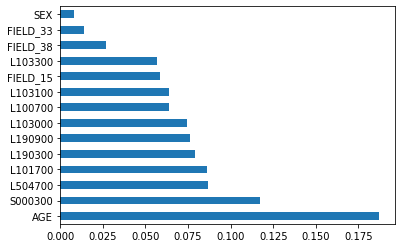

Index(['AGE', 'S000300', 'L504700', 'L101700', 'L190300', 'L190900', 'L103000',
       'L100700', 'L103100', 'FIELD_15', 'L103300', 'FIELD_38', 'FIELD_33',
       'SEX'],
      dtype='object')
1.0000000000000002


In [51]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(30).index)

print(np.sum(feat_importances.nlargest(30)))

In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[148,  52],
       [ 55, 145]], dtype=int64)

In [53]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.841
Accuracy on test set: 0.733


,0,1
0,148,52
1,55,145


In [54]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       200
           1       0.74      0.72      0.73       200

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.73      0.73      0.73       400



In [55]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.707
Accuracy on test set: 0.750


,0,1
0,154,46
1,54,146


In [56]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       200
           1       0.76      0.73      0.74       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



In [57]:
test.to_csv('test.txt',sep=',')
train.to_csv('train.txt',sep=',')

In [18]:
data4 = pd.read_csv("NextYearData_actualData_test.txt")
data5 = pd.read_csv("Predicted_NextYearData.txt")

In [58]:
test = data4[finalFeatures]

# test=data5[['P_AGE', 'P_S000300', 'P_FIELD_15', 'P_L190900',
#            'P_L103300', 'P_L504700', 'P_L190300','P_L103100', 
#            'P_L100700','P_FIELD_38', 'P_FIELD_33', 'P_SEX',
#            'P_L103000','P_L101700','CLASS']]


In [59]:
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on test set: 0.645


,0,1
0,60,40
1,31,69


In [60]:
print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       100
           1       0.63      0.69      0.66       100

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.64       200
weighted avg       0.65      0.65      0.64       200

